In [8]:
import pandas as pd
from statsmodels.api import tsa
from statsmodels.tsa.statespace.sarimax import SARIMAX
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt

In [10]:
wks_df = pd.read_pickle('data/LCL_unstack_wks.pkl')
wks_df.head()

tariff,Std,ToU
DateTime,,
2012-01-01,0.523669,0.528838
2012-01-08,0.540989,0.541720
2012-01-15,0.532780,0.526268
2012-01-22,0.550542,0.533956
2012-01-29,0.553962,0.503050


In [2]:
def decompose_DFs (df, mult_or_add, p):
    output = pd.DataFrame()
    for col in df.columns:
        name = col + '_Decomp'
        globals()[name] = tsa.seasonal_decompose(df[[col]], model = mult_or_add, period = p, extrapolate_trend=True) # extrapolate_trend = 'freq' to fill in nulls
        output[col + '_Trend'] = globals()[name].trend
        output[col + '_Seasonal'] = globals()[name].seasonal
        output[col + '_Residual'] = globals()[name].resid
    
    return output

In [3]:
# recall DF_dict
DF_dict = pd.read_pickle('data/DF_dict.pkl')

In [4]:
decomp_periods = [8760, 365, 52]
for i in range(len(DF_dict['DF'])):
    df = DF_dict['DF'][i]
    suf = DF_dict['period'][i]
    period = decomp_periods[i]
    globals()['decomps' + suf] = decompose_DFs(df, 'multiplicative', period)

For the ARIMA model, we will consider the weekly values as this has the least seasonality. The hourly and daily granularities will also likely exceed the computing resources available.

In [5]:
prds = ['Trend', 'Seasonal', 'Residual']

fig = make_subplots(rows=3, cols=1, subplot_titles=prds, shared_xaxes=False)

for i in range(len(prds)):
    prd = prds[i]
    df = decomps_wks

    fig.add_trace(                          # Plot standard tariff
        go.Line(
            x=df.index, y=df.iloc[:,i], 
            name = 'Standard', 
            line_color = '#F2A74B',
            legendgroup = prd
            ),
        row = i+1,
        col = 1,
    )

    fig.add_trace(                          # Plot variable tariff
        go.Line(
            x=df.index, y=df.iloc[:,i+3], 
            name = 'Variable',
            line_color = '#415885',
            legendgroup = prd
            ),
        row = i+1,
        col = 1
    )

    fig.update_xaxes(title_text='Date-Time', row=i+1, col=1)
    fig.update_yaxes(title_text='Multiplier', row=i+1, col=1)

    fig.update_layout(
        legend_title = "Tariff", 
        title = "Seasonal Decomposition of Weekly Average Power Consumption",
        legend_tracegroupgap=350,
        height= 1200
    )

fig.show()

c:\Users\triha\anaconda3\envs\timeseries\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




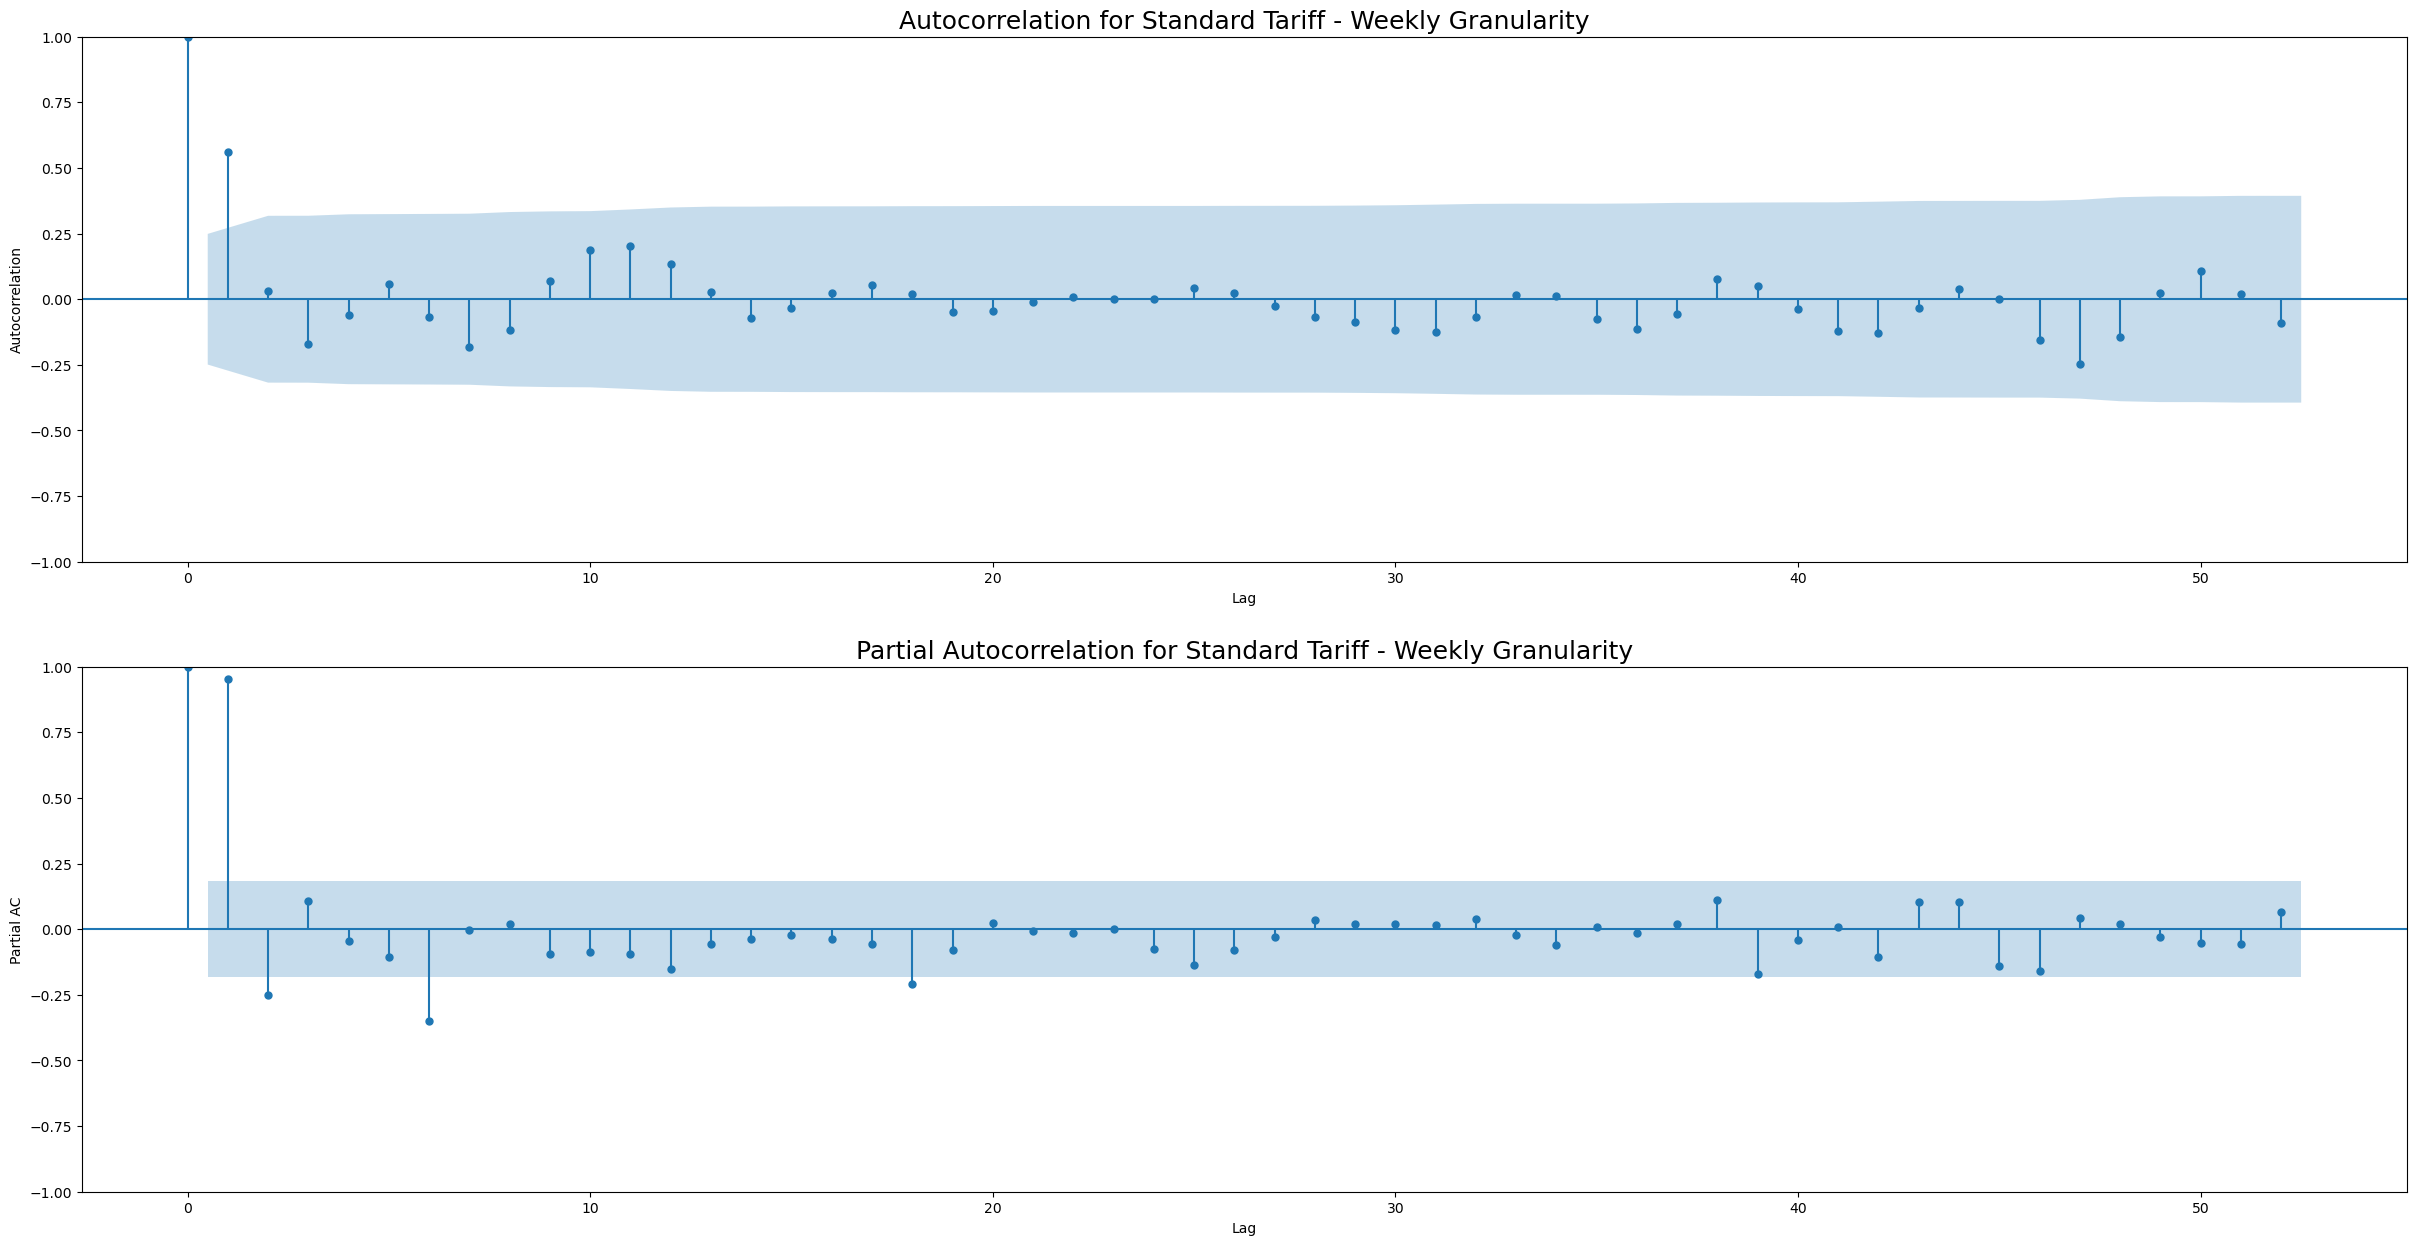

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.subplots(2, 1, figsize = (30, 15))

plt.subplot(2,1,1)
# put the acf plot on the current axis
plot_acf(wks_df["Std"].diff(52).dropna(), lags=52, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation for Standard Tariff - Weekly Granularity', fontsize = 18)

plt.subplot(2,1,2)
plot_pacf(wks_df["Std"], lags=52, ax=plt.gca(), method='ywm')
plt.xlabel('Lag')
plt.ylabel('Partial AC')
plt.title('Partial Autocorrelation for Standard Tariff - Weekly Granularity', fontsize = 18)
plt.show()

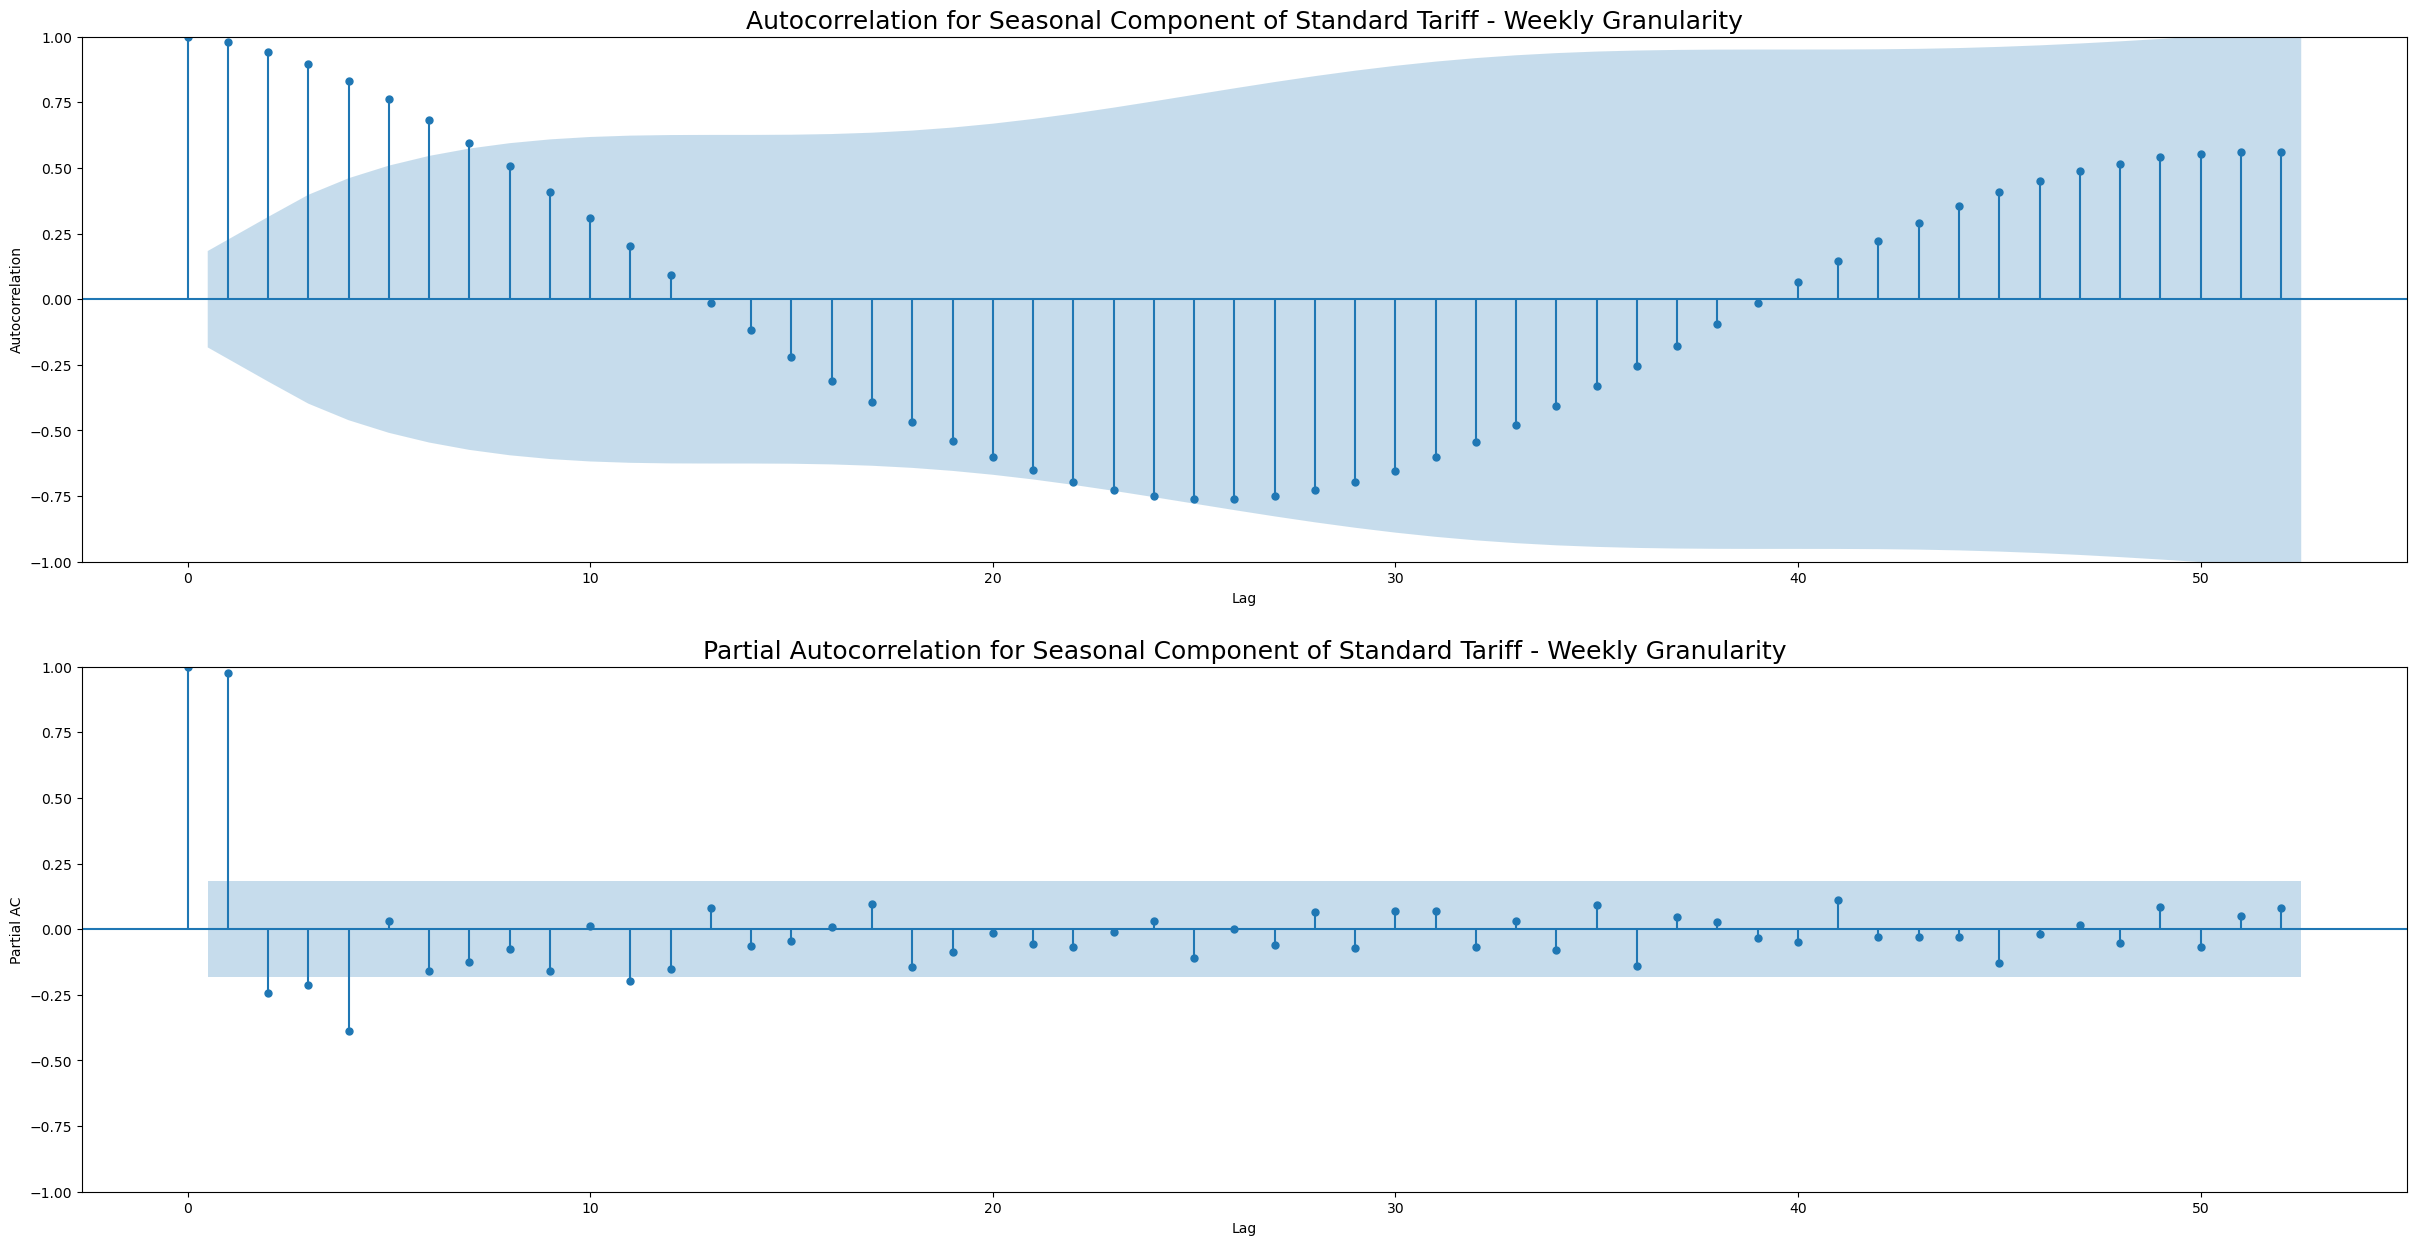

In [21]:
plt.subplots(2, 1, figsize = (30, 15))

plt.subplot(2,1,1)
# put the acf plot on the current axis
plot_acf(decomps_wks['Std_Seasonal'], lags=52, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation for Seasonal Component of Standard Tariff - Weekly Granularity', fontsize = 18)

plt.subplot(2,1,2)
plot_pacf(decomps_wks['ToU_Seasonal'], lags=52, ax=plt.gca(), method='ywm')
plt.xlabel('Lag')
plt.ylabel('Partial AC')
plt.title('Partial Autocorrelation for Seasonal Component of Standard Tariff - Weekly Granularity', fontsize = 18)
plt.show()

In [22]:
Std_test = wks_df['Std'].tail(round(0.2*wks_df["Std"].count()))
Std_train = wks_df['Std'].loc[wks_df.index < ToU_test.index[0]]

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

SARIMA_Std = SARIMAX(Std_train, order=(6, 1, 1), seasonal_order = (4,1,7,52), trend="c")
SARIMA_Std = SARIMA_Std.fit()

SARIMA_Std.summary()

c:\Users\triha\anaconda3\envs\timeseries\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                               SARIMAX Results                                                
==============================================================================================================
Dep. Variable:                                                    Std   No. Observations:                   91
Model:             SARIMAX(2, 1, 1)x(4, 1, [1, 2, 3, 4, 5, 6, 7], 52)   Log Likelihood                  76.662
Date:                                                Mon, 31 Oct 2022   AIC                           -121.325
Time:                                                        13:46:40   BIC                            -95.123
Sample:                                                    01-01-2012   HQIC                          -112.002
                                                         - 09-22-2013                                         
Covariance Type:                                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.200      0.001      0.999      -0.392       0.392
ar.L1          0.8055      0.188      4.294      0.000       0.438       1.173
ar.L2         -0.4563      0.177     -2.576      0.010      -0.804      -0.109
ma.L1         -0.8579      0.202     -4.239      0.000      -1.255      -0.461
ar.S.L52    5.167e-05    761.082   6.79e-08      1.000   -1491.694    1491.694
ar.S.L104   9.345e-06      0.036      0.000      1.000      -0.071       0.071
ar.S.L156   9.346e-06      0.002      0.005      0.996      -0.004       0.004
ar.S.L208   9.346e-06      0.002      0.004      0.997      -0.004       0.004
ma.S.L52    4.733e-06    761.083   6.22e-09      1.000   -1491.696    1491.696
ma.S.L104   8.762e-06      0.123   7.14e-05      1.000      -0.240       0.240
ma.S.L156   8.762e-06      0.051      0.000      1.000      -0.100       0.100
ma.S.L208   8.762e-06      0.044      0.000      1.000      -0.086       0.086
ma.S.L260   8.783e-06      0.023      0.000      1.000      -0.046       0.046
ma.S.L312   8.783e-06      0.042      0.000      1.000      -0.083       0.083
ma.S.L364   8.783e-06      0.057      0.000      1.000      -0.113       0.113
sigma2         0.0010      0.000      4.680      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                24.76
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.04   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.03e+27. Standard errors may be unstable.
"""

In [27]:
predictions = SARIMA_Std.predict(start=0, end=len(Std_train)+len(Std_test)-1)

In [28]:
fig = go.Figure()
fig.add_trace(go.Line(x=Std_train.index, y=Std_train, mode='lines', name="Train"))
fig.add_trace(go.Line(x=Std_test.index, y=Std_test, mode='lines', name="Test"))
fig.add_trace(go.Line(x=predictions.index, y=predictions, mode='lines', name="Predictions"))

c:\Users\triha\anaconda3\envs\timeseries\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




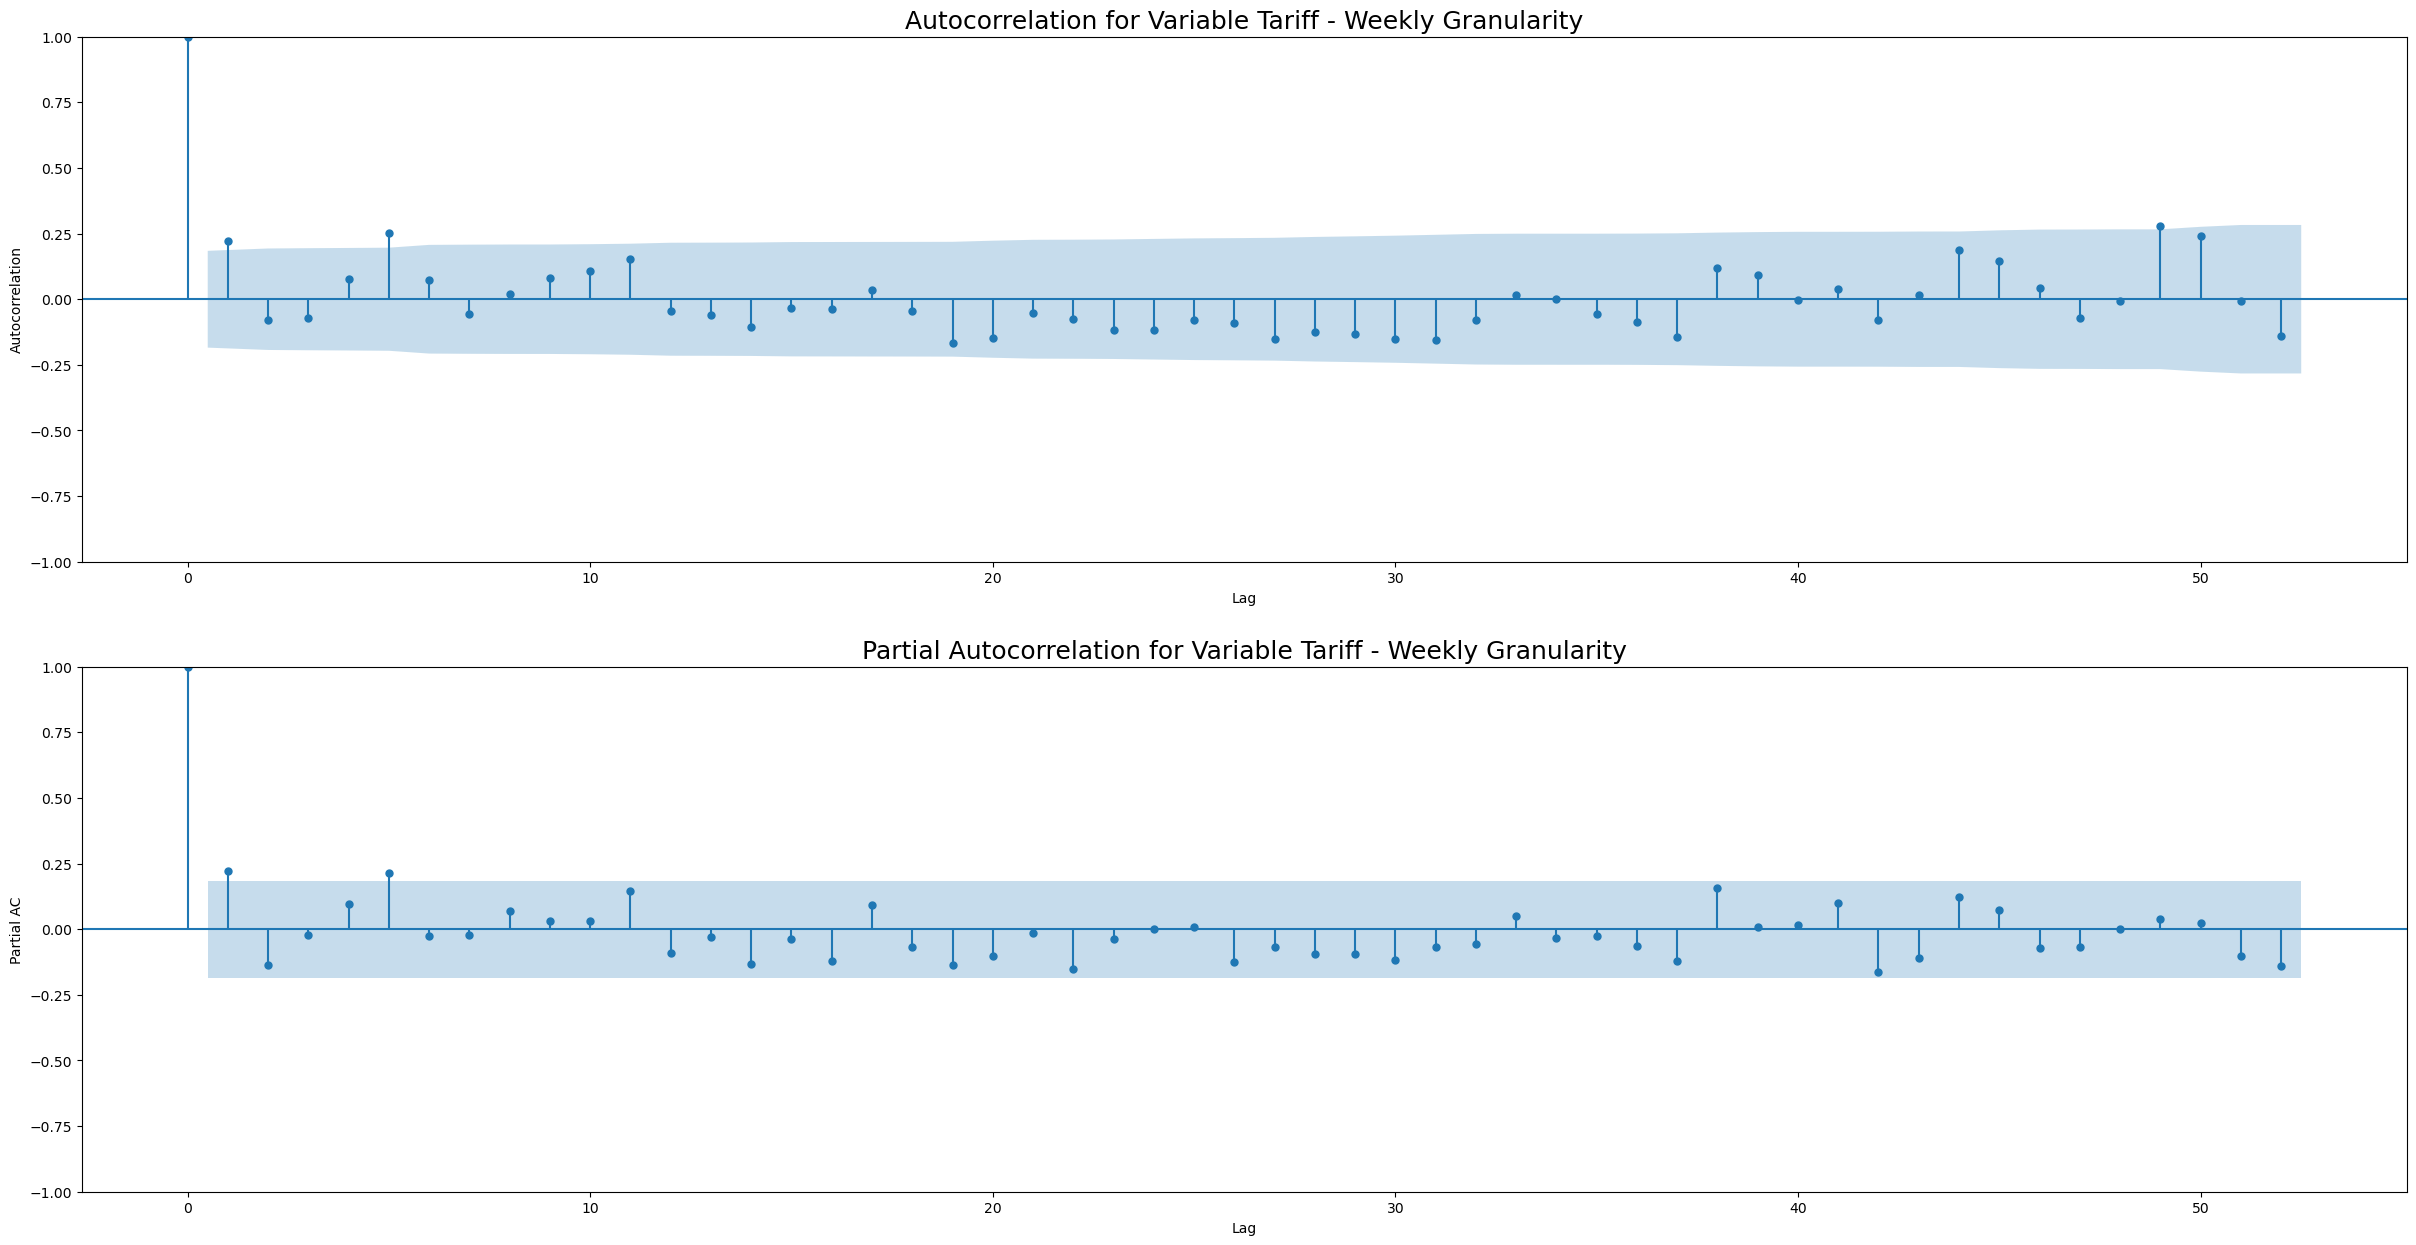

In [75]:
plt.subplots(2, 1, figsize = (30, 15))

plt.subplot(2,1,1)
# put the acf plot on the current axis
plot_acf(wks_df["Std"].diff(1).dropna(), lags=52, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation for Variable Tariff - Weekly Granularity', fontsize = 18)

plt.subplot(2,1,2)
plot_pacf(wks_df["Std"].diff(1).dropna(), lags=52, ax=plt.gca(), method='ywm')
plt.xlabel('Lag')
plt.ylabel('Partial AC')
plt.title('Partial Autocorrelation for Variable Tariff - Weekly Granularity', fontsize = 18)
plt.show()

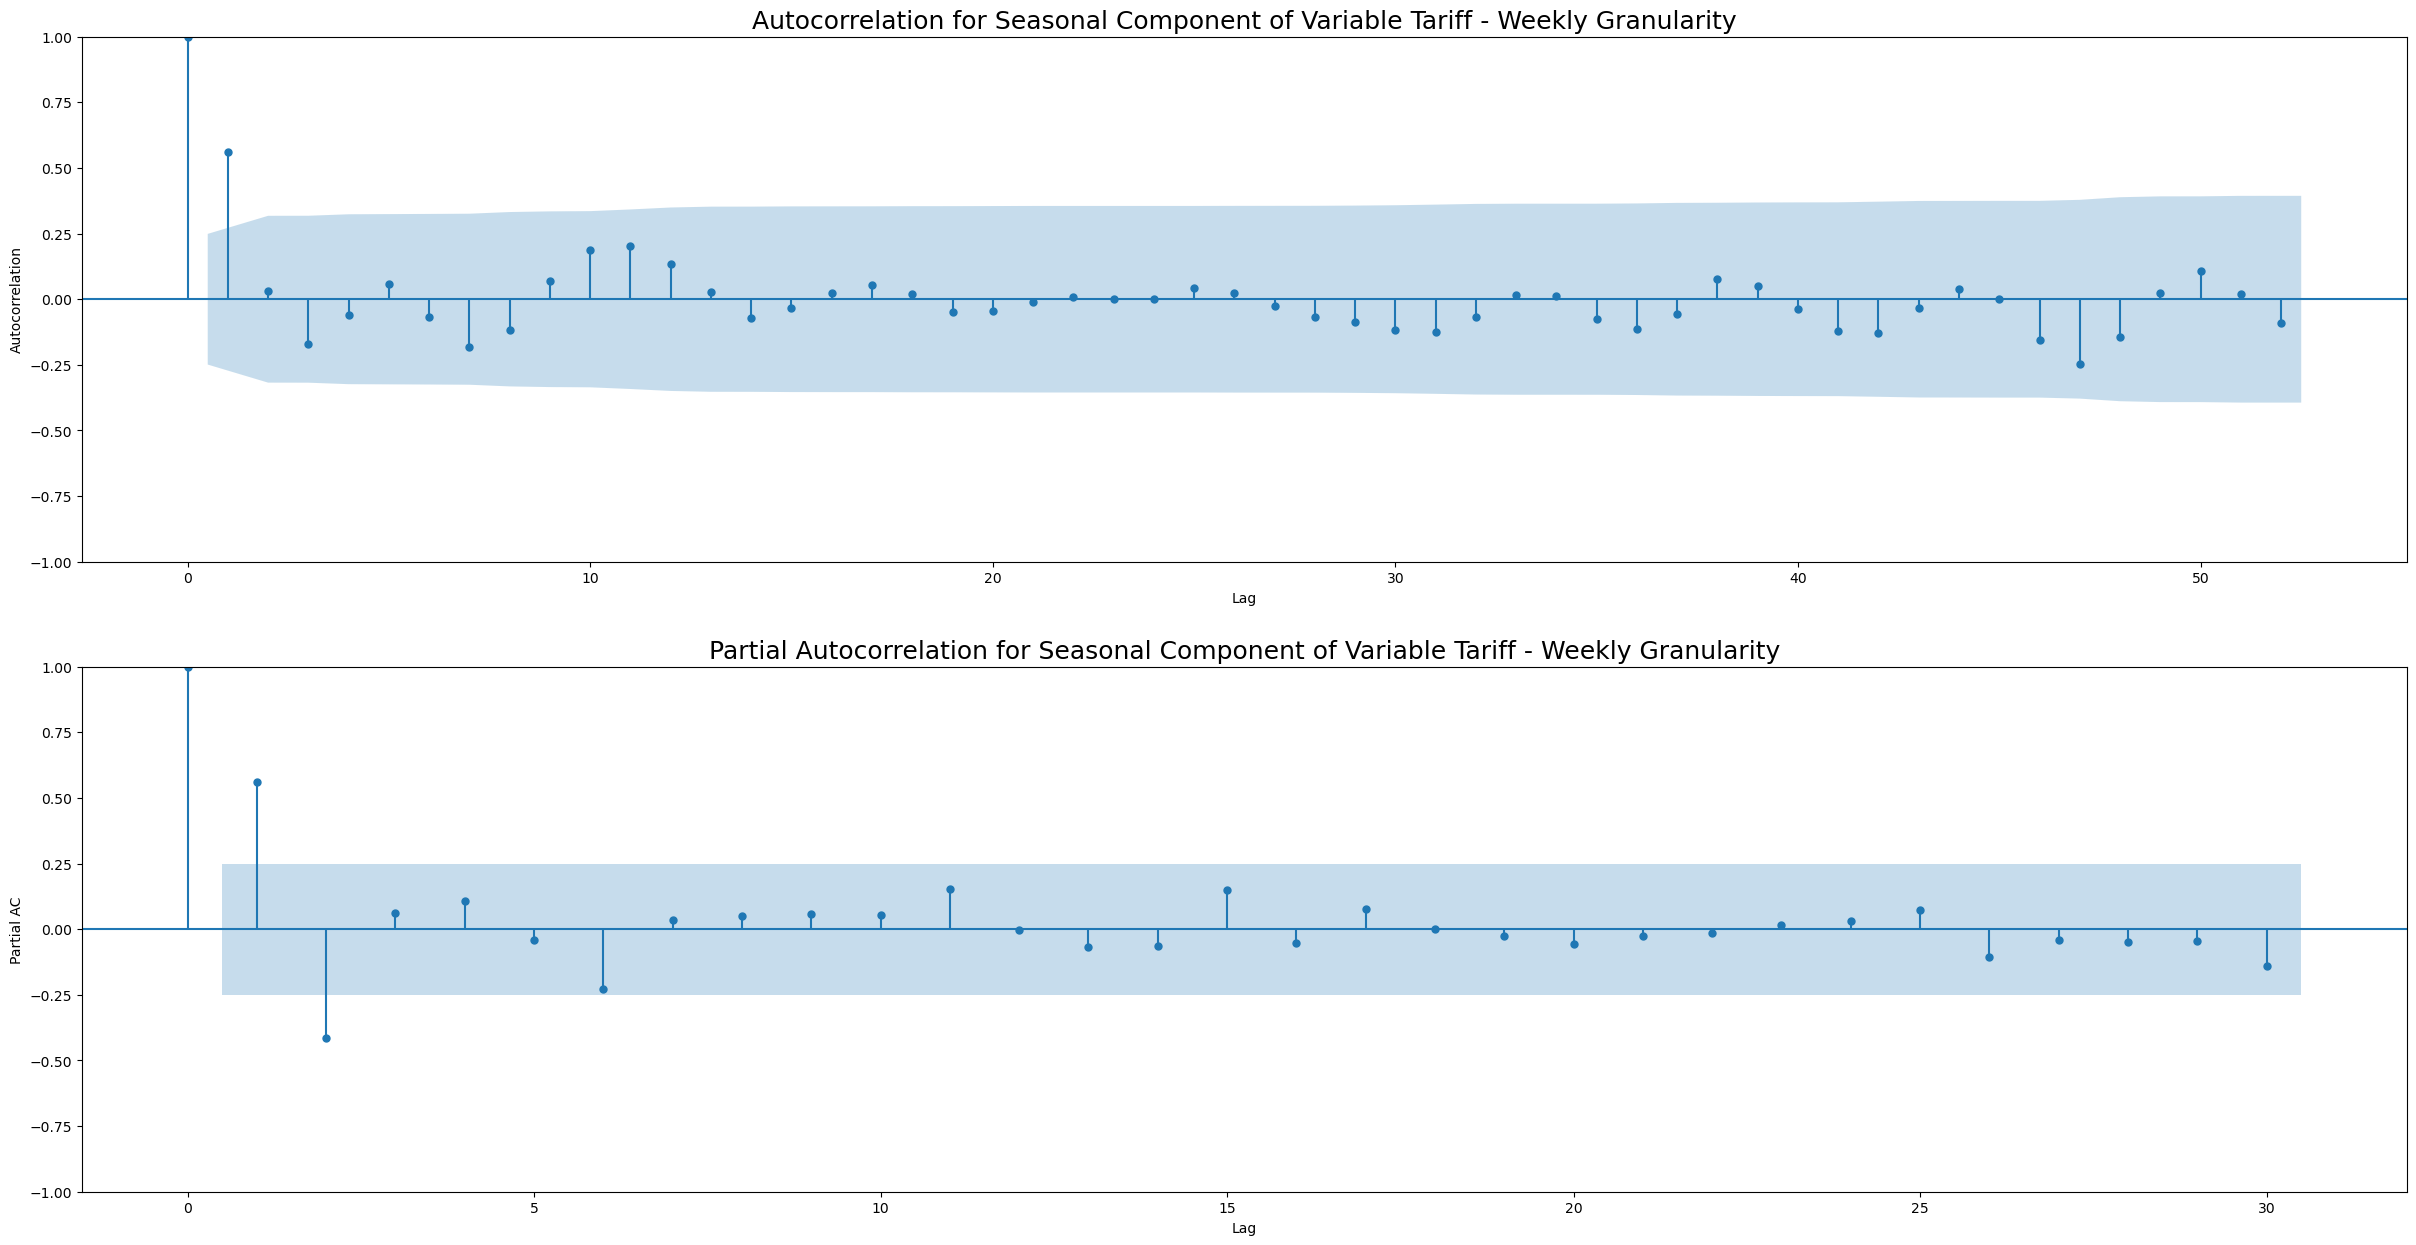

In [78]:
plt.subplots(2, 1, figsize = (30, 15))

plt.subplot(2,1,1)
# put the acf plot on the current axis
plot_acf(wks_df["Std"].diff(52).dropna(), lags=52, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation for Seasonal Component of Variable Tariff - Weekly Granularity', fontsize = 18)

plt.subplot(2,1,2)
plot_pacf(wks_df["Std"].diff(52).dropna(), lags=30, ax=plt.gca(), method='ywm')
plt.xlabel('Lag')
plt.ylabel('Partial AC')
plt.title('Partial Autocorrelation for Seasonal Component of Variable Tariff - Weekly Granularity', fontsize = 18)
plt.show()

In [31]:
ToU_test = wks_df['ToU'].tail(round(0.2*wks_df["ToU"].count()))
ToU_train = wks_df['ToU'].loc[wks_df.index < ToU_test.index[0]]

In [32]:
ToU_train.count()

91

In [87]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

SARIMA_ToU = SARIMAX(ToU_train, order=(5, 1, 5), seasonal_order = (2,1,1,52), trend="c")
SARIMA_ToU = SARIMA_ToU.fit()

SARIMA_ToU.summary()

c:\Users\triha\anaconda3\envs\timeseries\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\triha\anaconda3\envs\timeseries\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

c:\Users\triha\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                  ToU   No. Observations:                   91
Model:             SARIMAX(5, 1, 5)x(2, 1, [1], 52)   Log Likelihood                  81.564
Date:                              Mon, 31 Oct 2022   AIC                           -133.128
Time:                                      15:52:07   BIC                           -108.564
Sample:                                  01-01-2012   HQIC                          -124.388
                                       - 09-22-2013                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0012      0.040      0.030      0.976      -0.077       0.080
ar.L1         -0.1261     13.329     -0.009      0.992     -26.250      25.998
ar.L2         -0.3262      7.450     -0.044      0.965     -14.929      14.276
ar.L3         -0.0043      6.984     -0.001      1.000     -13.692      13.684
ar.L4          0.2161      4.415      0.049      0.961      -8.437       8.869
ar.L5         -0.0201      3.056     -0.007      0.995      -6.010       5.969
ma.L1         -0.0594     13.392     -0.004      0.996     -26.308      26.189
ma.L2         -0.1711      6.013     -0.028      0.977     -11.956      11.614
ma.L3         -0.4582      3.553     -0.129      0.897      -7.422       6.506
ma.L4         -0.2846      6.287     -0.045      0.964     -12.607      12.038
ma.L5          0.1304      6.751      0.019      0.985     -13.102      13.363
ar.S.L52       0.0050     30.097      0.000      1.000     -58.984      58.994
ar.S.L104     -0.0011      0.017     -0.062      0.951      -0.035       0.033
ma.S.L52      -0.0055     30.097     -0.000      1.000     -58.995      58.984
sigma2         0.0008      0.000      2.601      0.009       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 4.11
Prob(Q):                              0.96   Prob(JB):                         0.13
Heteroskedasticity (H):               0.08   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.5e+23. Standard errors may be unstable.
"""

In [91]:
# ToU_pred = SARIMA_ToU.predict(start=0, end=len(ToU_train)+len(ToU_test)-1)
ToU_pred = SARIMA_ToU.predict(start=wks_df.index[0], end = wks_df.index[wks_df.shape[0]-1])

ToU_pred_train = SARIMA_ToU.predict(ToU_train.index[0], end=ToU_train.index[len(ToU_train)-1])
ToU_pred_test = SARIMA_ToU.predict(ToU_test.index[0], end=ToU_test.index[len(ToU_test)-1])

In [92]:
fig = go.Figure()
fig.add_trace(go.Line(x=ToU_train.index, y=ToU_train, mode='lines', name="Train"))
fig.add_trace(go.Line(x=ToU_test.index, y=ToU_test, mode='lines', name="Test"))
fig.add_trace(go.Line(x=ToU_test.index, y=ToU_pred_test, mode='lines', name="Test Predictions"))
fig.add_trace(go.Line(x=ToU_train.index, y=ToU_pred_train, mode='lines', name="Train Predictions"))
fig.show()

In [70]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [93]:
# mean_absolute_error(ToU_test.iloc[:len(ToU_test)-1],ToU_pred_test)
mean_absolute_percentage_error(ToU_test,ToU_pred_test)

0.11804105008546953

In [94]:
mean_squared_error(ToU_test,ToU_pred_test)

0.0033306825342393287

In [95]:
mean_absolute_error(ToU_train,ToU_pred_train)

0.02634650950011587